In [1]:
#tahap1
import os
import warnings
warnings.filterwarnings('ignore')

fpaths = []
labels = []
spoken = []
dir0='audio'

for item in os.listdir(dir0):
    for isi in os.listdir(dir0+'/' + item):
        fpaths.append(dir0+'/' + item + '/' + isi)
        labels.append(item)
        if item not in spoken:
            spoken.append(item)

#print('Words spoken=>', spoken)
#print("")
#print('label=>', labels)
#print("")
#print('fpath=>',fpaths)
print('ok')

ok


In [2]:
print(spoken)

['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']


In [3]:
#for item in os.listdir('audio'):
#    print(item)
#    for w in os.listdir('audio/' + item):
#        print(item,'\t',w)
#print(labels)
#for n, l in enumerate(set(labels)):
#    print(n,l)

In [3]:
#tahap2 - Pembentukan data training 7x15  ( 7 kelas, masing2 kelas diulang 15)
from scipy.io import wavfile
import numpy as np

data = np.zeros((len(fpaths), 32000)) #32000 data list penampung sementara
print('data awal=>', data.shape)
maxsize = -1  # size yg terbesar

for n,file in enumerate(fpaths):
    _ , d = wavfile.read(file)    
    #print(n,file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]

#terakhir
data = data[:,:maxsize] # agar panjang data sama

#Each sample file is one row in data, and has one entry in labels
print('data akhir=>', data.shape,type(data))
print('Number of files total:', data.shape[0])


#PELABELAN DATA 0-6, ada 7 kelas

all_labels = np.zeros(data.shape[0]) # 105 data, numpy
#print('Labels and label indices', all_labels)
#print(labels)
for n, l in enumerate(set(labels)): #untuk menandai nama lebel 4,4,2,....
    #all_labels[np.array([i for i,item in enumerate(labels) if item == l])] = n 
    for i,item in enumerate(labels):
        if item == l:
            all_labels[i]=n                
    
all_labels.sort() #agar label nya urut

print('all_labels', all_labels,'total=>',len(all_labels),type(all_labels))

#print(data[15])
#print(len(data[30]))
#print(data[15][0])
#print(data[15][1])
print('ok')

data awal=> (105, 32000)
data akhir=> (105, 6966) <class 'numpy.ndarray'>
Number of files total: 105
all_labels [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6.] total=> 105 <class 'numpy.ndarray'>
ok


In [4]:
#tahap3, STFT = SORT TIME FOURIER TRANSFORM
# DOMAIN WAKTU KE DOMAIN FREKUENSI pada interval waktu tertentu (size tertentu)
# fftsize=64 apa penjelasan ?
# overlap_pct=.5  kenapa ?
import scipy

#seting parameter
n_dim=4          #dimensi fitur 2=>45.45  4,6,8 => 81.82   10=>63.64
                # n_dim=4 ndim=6 , akrasi sama, pilin 4 saja
    
fftsize0=60     #30 -> 53   40 ->45.45 50=> 83.64 60->81.82   70->53   100=>72.73, 
                #fftsize0 makin kecil akurasi turun. 40 => 18.18 untuk n_dim-4=6
                #fftsize makin besar, panjangnya fitur turun => len=136 ,akurasi=100
                #fftsize=100, akurasi=100 len=136
                #fftsize=90, akurasi=100 len=153
        
overlap0=0.5    #0.1 -> 72.73   0.3=>45.45  0.5=0.7->81.82     0.9 -> 81/82 LAMA
                #overlap makin besar, lama dan len fitur besar

#25 => eror , simgular matrik
#35 => 38.10
#40 => 19.05 JATUH !!! len=347
#50 => 61.90
#55 => 81.90
#58 => 66.67
#59 => 61.90
#60 => 90.48    overlap0: 0.45=>76.19  0.5=90.48   0.55 =>76.19   0.6 => 85.71 0.7=>85.71
#61 => 71.43
#62 => 71.43
#65 => 85.71
#70 => 85.71
#75 => 76.19
#90 => 79.19
#100 => 76.19 (Tapi gagal, saat test=0.2)#120 => 71.43

#penemuan baru, 100%, 17 Desember 2021 Siang 2.06 PM
#n_dim=4
#fftsize0=100
#overlap0=0.5
#random_state=11,4,0
#test=0.1=>akurasi 100
#TAPI JATUH SAAT utk test=0.2 =>akurasi 76.19

#penemuan baru lagi, sore 2.46 pm, akurasi=90.48
#n_dim=4
#fftsize0=60 => 90.48   fftsize0=70=65 => 85.71
#fftsize0=50 => 61.90
#overlap0=0.5
#random_state=4
#test=0.1=>akurasi 100

# TERBAIK, STABIL, KEMBALI ASAL
# sama utk test=0.1 dan 02, akurasi 90.91
#n_dim=4
#fftsize0=60
#overlap0=0.5

def stft(x, fftsize=60, overlap_pct=0.5): #asli 64
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.hanning(fftsize + 1)[:-1]    
    # penjelasan hanning di buku
    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

print('ok')

ok


(231, 30)
ok4


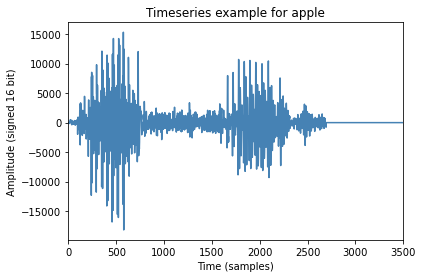

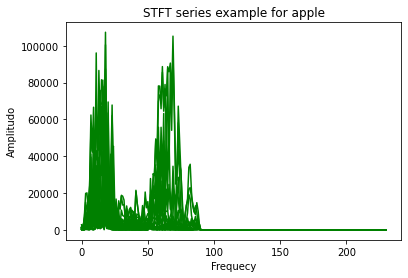

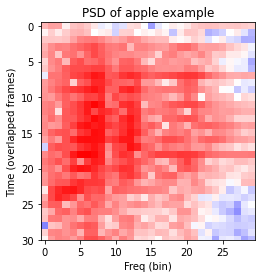

In [5]:
#tahap4 - PLOT GRAFIK, SAMPLE
import matplotlib.pyplot as plt

#1. plot wave form - domai waktu
plt.plot(data[0, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

#2. plot wave form - domai waktu
hasil_stft=abs(stft(data[0, :],60,0.5))
plt.plot(hasil_stft, color='green')
plt.title('STFT series example for %s'%labels[0])
#plt.xlim(0, 500)
plt.xlabel('Frequecy')
plt.ylabel('Amplitudo')
plt.figure()

#3 PSD
# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='bwr', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

print('ok4')

In [6]:
#tahap5, MENCARI TITIK TERTINGGI DARI SINYAL

from numpy.lib.stride_tricks import as_strided

#Peak detection using the technique described here:
#http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html 

def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
        
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

print('ok4')

ok4


[ 7 20]
[23014   567]
ok5


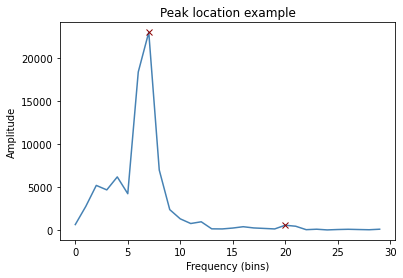

In [7]:
#tahap6 - plot titik tertimggi
#plot_data = np.abs(stft(data[20, :])) [15, :]
plot_data = np.abs(stft(data[20, :]))[15, :]
# plot_data = np.abs(stft(data[3, :])) [531, :]

values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1] # sumbu x
fv = values[values > -1] # sumbu y
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')

print(fp)
print(fv)
print('ok5')

In [8]:
#tahap7 - FITUR EKSTRAKSI MENGGUNAKAN MFCC, CARI PENJELASAN, ISI BUKU

# This processing (top freq peaks) only works for single speaker case...
# need better features for multispeaker !
# MFCC (cara lain :  cara deepNN / automatic feature extraction) could be interesting

#n_dim = 4  # ambil jumlah fitur = 6, untuk n_peaks per blok

all_obs = []
ll=data.shape[0]
k=0
N=int(ll/10)
for i in range(ll): #105
    d = np.abs(stft(data[i, :],fftsize0,overlap0)) #60  0.5
    
    #n_dim = 4  # ambil jumlah fitur = 6, untuk n_peaks per blok
    
    # koed=6   - akurasi 90.91
    
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks = n_dim)
        obs[:, r] = t.copy()
        
    # utk tampilan setiap 10% proses
    if i % 10 == 0:
        print("Processed obs %s" % (k*10),' %')
        k=k+1
    # datanya dimasukan ke array
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)
#print(all_obs)
print('ok')
print(all_obs.shape)

Processed obs 0  %
Processed obs 10  %
Processed obs 20  %
Processed obs 30  %
Processed obs 40  %
Processed obs 50  %
Processed obs 60  %
Processed obs 70  %
Processed obs 80  %
Processed obs 90  %
Processed obs 100  %
ok
(105, 4, 231)


In [10]:
# print(all_obs.shape)
# print(n_dim)

In [9]:
#tahap8 - KLASIFIKASI PAKAI HMM,   METHOD
import scipy.stats as st
import numpy as np

class gmmhmm:
    #This class converted with modifications from https://code.google.com/p/hmm-speech-recognition/source/browse/Word.m
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.covs = None
        self.n_dims = None
        
        
    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])
         
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha
    
    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);
           
        beta[:, -1] = np.ones(B.shape[0])
            
        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta
    
    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B
    
    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)
    
    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)
    
    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self
    
    def _em_step(self, obs): 
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]
        
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)
        
        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))
        
        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
              
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)
        
        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)
        
        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
        
        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)
        
        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)
        
        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]
        
        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood
    
    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self
    
    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

if __name__ == "__main__":
    rstate = np.random.RandomState(0)
    t1 = np.ones((4, 40)) + .001 * rstate.rand(4, 40)
    t1 /= t1.sum(axis=0)
    t2 = rstate.rand(*t1.shape)
    t2 /= t2.sum(axis=0)
    
    m1 = gmmhmm(2)
    m1.fit(t1)
    m2 = gmmhmm(2)
    m2.fit(t2)
    
    m1t1 = m1.transform(t1)
    m2t1 = m2.transform(t1)
    print("Likelihoods for test set 1")
    print("M1:", m1t1)
    print("M2:", m2t1)
    print("Prediction for test set 1")
    print("Model", np.argmax([m1t1, m2t1]) + 1)
    print()
    
    m1t2 = m1.transform(t2)
    m2t2 = m2.transform(t2)
    print("Likelihoods for test set 2")
    print("M1:", m1t2)
    print("M2:", m2t2)
    print("Prediction for test set 2")
    print("Model", np.argmax([m1t2, m2t2]) + 1)
    
print('ok7')

Likelihoods for test set 1
M1: 221.38828575112734
M2: 165.27280230776483
Prediction for test set 1
Model 1

Likelihoods for test set 2
M1: 33.19459421485196
M2: 59.15274753052989
Prediction for test set 2
Model 2
ok7


In [10]:
#tahap9, MENGATUR JMLAH TRANING DAN TESTING, SECARA RANDOM

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=4) #random_state=pengaruh akurasi

# random_state=0 => akurasi = 90.91
# random_state=1 => akurasi = 54.55
# random_state=2 => akurasi = 72.73
# random_state=3 => akurasi = 81.82
# random_state=4 => akurasi = 90.91
# random_state=5 => akurasi = 72.73
# random_state=6 => akurasi = 63.64
# random_state=7 => akurasi = 81.81
# random_state=8 => akurasi = 72.72
# random_state=9 => akurasi = 45.45
# random_state=10 => akurasi = 81.82
# random_state=11 => akurasi = 90.91

sss.get_n_splits(all_labels)

#print (sss)

for n,i in enumerate(all_obs):  #NORMALISASI, DIBAGI JMLAH SEMUNYA,PROBABILITAS
    all_obs[n] /= all_obs[n].sum(axis=0)

for train_index, test_index in sss.split(all_obs,all_labels):
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

print('ok8')
#print(y_test)

Size of training matrix: (84, 4, 231)
Size of testing matrix: (21, 4, 231)
ok8


In [13]:
#print(X_train[0])
#print("")
#print(X_train[104-11])

In [14]:
# tahap10 - PROSES KLASIFIKASI HMM  =>  CARI FILE HASIL TRAINING
# ys = set(all_labels)

# print('Proses Training HMM ..., HASIL TRAINING DI SIMPAN = ms')
# ms = [gmmhmm(4) for y in ys]

# print(ms)

# _ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]

# print('Proses Testing HMM ...')
# ps = [m.transform(X_test) for m in ms]
# print(ps)

# res = np.vstack(ps) #diubuabh ke numpy, persis tabel asli dari array asal
# predicted_labels = np.argmax(res, axis=0)
# missed = (predicted_labels != y_test)
# print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))
# print('ok')

In [11]:
#TRAINING - PENJELASAN

ys = set(all_labels)
ms=[]
for y in ys:
    ms.append(gmmhmm(n_dim)) # 6 = asli

print(ms)

print('Proses Training HMM ...')
for m, y in zip(ms, ys):
    print(m,'|',y)
    _ = [m.fit(X_train[y_train == y, :, :])]

print('Proses Testing HMM ...')
ps=[]
for m in ms:
    print(m)
    ps.append(m.transform(X_test))

# print('ps =>',ps)

res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

[<__main__.gmmhmm object at 0x000001E41D62AC70>, <__main__.gmmhmm object at 0x000001E41D62ACA0>, <__main__.gmmhmm object at 0x000001E41D62ADC0>, <__main__.gmmhmm object at 0x000001E41D62AE80>, <__main__.gmmhmm object at 0x000001E41D62AEE0>, <__main__.gmmhmm object at 0x000001E41D62AF40>, <__main__.gmmhmm object at 0x000001E41D62AA00>]
Proses Training HMM ...
<__main__.gmmhmm object at 0x000001E41D62AC70> | 0.0
<__main__.gmmhmm object at 0x000001E41D62ACA0> | 1.0
<__main__.gmmhmm object at 0x000001E41D62ADC0> | 2.0
<__main__.gmmhmm object at 0x000001E41D62AE80> | 3.0
<__main__.gmmhmm object at 0x000001E41D62AEE0> | 4.0
<__main__.gmmhmm object at 0x000001E41D62AF40> | 5.0
<__main__.gmmhmm object at 0x000001E41D62AA00> | 6.0
Proses Testing HMM ...
Test accuracy: 90.48 percent


In [16]:
# pip install pickle-mixin

In [12]:
def AmbilFitur(d):
  
    #1. SAMAKAN UKURAN
#     _ , d = wavfile.read(nama_file)
    s = np.zeros(32000) #32000 data list penampung sementara
   
    s[:d.shape[0]] = d
    s = s[:maxsize]# agar panjang data sama
    
    #2. STFT
    d = np.abs(stft(s,fftsize0,overlap0)) #60  0.5
#     print('d.shape',d.shape)    
    
    #3. FITUR EKSTRAKSI, 4 PUNCAK TIAP INTEVAL
    n_dim = 4  # ambil 4 PUNCAK TIAP WINDOWS INTERVAL, =>  n_peaks  

    obs = np.zeros((n_dim, d.shape[0]))
    #print('awal',obs.shape)

    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks = n_dim)
        obs[:, r] = t.copy()
    
    #4. NORMALISASI
    obs = obs/obs.sum(axis=0)
    return obs

print('ok')

ok


In [13]:
import joblib

# Save the model as a pickle in a file
joblib.dump(ms, 'save_ms_2.pkl')
joblib.dump(spoken, 'save_spoken_2.pkl')
print('ok')

ok


In [19]:
# import pickle

# with open('save_ms','wb') as r:
#     pickle.dump(ms,r)

# with open('save_spoken','wb') as r:
#     pickle.dump(spoken,r)
    
# print('ok')

In [14]:
ms_load = joblib.load('save_ms_2.pkl')
spoken_load = joblib.load('save_spoken_2.pkl')
# maxsize = spoken_load[-1]
# del spoken_load[-1]
print('ok')

ok


In [21]:
# with open('save_ms','rb') as r:
#     ms_load=pickle.load(r)

# with open('save_spoken','rb') as r:
#     spoken_load=pickle.load(r)
    
# # maxsize = spoken_load[-1]
# # del spoken_load[-1]
# print('ok')

In [22]:
#print(ys)
#print(X_train)
#print(X_train.shape)
#print(y_train)
#print(y_train.shape)

#JADI SIMPAN X_train, y_train)

#type(ms)
#print(ps[0])
#print(ps[1])
#res = np.vstack(ps)
#print(res)
#print(res[0,:])
#print(res[1,:])
#print(predicted_labels)
#print(y_test)

In [23]:
#TEST UTK 1 DATA AUDIO
#print('Proses Testing HMM, semua data testing AUDIO')

#ps = [m.transform(X_test) for m in ms]
#res = np.vstack(ps)
#print(res)
#print('ok')
#print(np.argmax(res, axis=0))
#print(y_test)

#predicted_labels = np.argmax(res, axis=0)
#missed = (predicted_labels != y_test)
#print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))
#print('ok')


In [24]:
# print('Proses Testing HMM, 1 AUDIO DARI DATA TESTING')
# # SIMPAN DATA TRAINING = ms

# ke=8  # ke=8 eror
# print('INPUT =',spoken[int(y_test[ke])])
# x = X_test[ke,:,:] 

# #PROSES TESTING
# ps = [m.transform(x) for m in ms]

# res = np.vstack(ps)
# #print(res)
# print('ok')
# print(np.argmax(res, axis=0))
# print(y_test[ke])
# if np.argmax(res, axis=0)==y_test[ke]:
#     print('True')
# else:
#     print('False')
# pos=np.argmax(res, axis=0)[0]

# print('HASIL TESTING =',spoken[pos])


In [25]:
# print(len(y_train))

In [26]:
# print(len(y_test))

In [27]:
# ke=1 # ke=8 eror
# print('INPUT =',spoken[int(y_test[ke])])
# x = X_test[ke,:,:]
# print()
# print(x.shape)
# x

In [15]:
print(spoken_load)
print(ms_load)

['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']
[<__main__.gmmhmm object at 0x000001E41B2F5A00>, <__main__.gmmhmm object at 0x000001E41B2F5FA0>, <__main__.gmmhmm object at 0x000001E41B2DE250>, <__main__.gmmhmm object at 0x000001E41B2DE6D0>, <__main__.gmmhmm object at 0x000001E41D64B2B0>, <__main__.gmmhmm object at 0x000001E41D64B670>, <__main__.gmmhmm object at 0x000001E41D64B970>]


In [29]:
# print('Proses Testing HMM, 1 AUDIO DARI FILE')

#1. load
#nama_file = 'audio/apple/apple01.wav'
#nama_file = 'audio/pineapple/pineapple15.wav'
# nama_file = 'audio/banana/banana03.wav'
# nama_file = 'audio/orange/orange01.wav'
# nama_file = 'audio/lime/lime02.wav'
# #nama_file = 'audio/kiwi/kiwi01.wav'
# #nama_file = 'audio/peach/peach01.wav'
# # nama_file = 'dataset/alif/alif3.wav'

# s = np.zeros(32000) #32000 data list penampung sementara

# _ , d = wavfile.read(nama_file)    
# # print(d)
# s[:d.shape[0]] = d

# s = s[:maxsize] # agar panjang data sama
# print(s)


# #2. STFT
# d = np.abs(stft(s,fftsize0,overlap0)) #60  0.5
# print('d.shape',d.shape)    

# #3. FITUR EKSTRAKSI, 4 PUNCAK TIAP INTEVAL
# #n_dim = 4  # ambil 4 PUNCAK TIAP WINDOWS INTERVAL, =>  n_peaks  

# obs = np.zeros((n_dim, d.shape[0]))
# print('awal',obs.shape)

# for r in range(d.shape[0]):
#     _, t = peakfind(d[r, :], n_peaks = n_dim)
#     obs[:, r] = t.copy()
    
# #4. NORMALISASI
# obs = obs/obs.sum(axis=0)

# #5. TESTING 1 FILE AUDIO
# x=obs

# ps = [m.transform(x) for m in ms]  # data training ms

# print(ps)
# res = np.vstack(ps)

# #6. HASIL TESTING
# pos=np.argmax(res, axis=0)[0]
# print('HASIL TESTING =',spoken[pos])


In [30]:
#my_list=ms
#with open('ms.txt', 'w') as f:
#    for item in my_list:
#        f.write("%s\n" % item)
#f.close()

In [31]:
#my_list=[]
#with open('ms.txt', 'r') as f:
#    for x in f:
#        my_list.append(x)
#f.close()
#print(my_list)
#print(len(my_list))

In [32]:
# save file

In [33]:
# print(ms)

In [16]:
print(maxsize)

6966


In [35]:
# print(spoken)

In [36]:
# spoken.append(maxsize)
# print('ok')

In [20]:
# nama_file = 'audio/apple/apple01.wav'
nama_file = 'audio/pineapple/pineapple15.wav'
# nama_file = 'audio/banana/banana03.wav'
# nama_file = 'audio/orange/orange08.wav'
# nama_file = 'audio/lime/lime02.wav'
# nama_file = 'audio/kiwi/kiwi01.wav'
# nama_file = 'audio/peach/peach15.wav'

# LOAD 
_ , d = wavfile.read(nama_file)
print(d)

#AMBILFITUR
x = AmbilFitur(d)
# print(x)
print(x.shape)
print(maxsize)


#TESTING
ps = [m.transform(x) for m in ms_load]  # data training ms
#print(ps)
res = np.vstack(ps)

#HASIL TESTING
pos=np.argmax(res, axis=0)[0]
print(nama_file,' =>  HASIL TESTING =',spoken_load[pos])

[  98  113   80 ... -150 -116  -53]
(4, 231)
6966
audio/pineapple/pineapple15.wav  =>  HASIL TESTING = pineapple


In [23]:
import os
import time
#import tkinter as tk
from tkinter import *
#from tkinter import messagebox

import sounddevice as sd
import soundfile as sf
# import proses as pr

fs=8000 # sampling per detik, 8000 44100
#N=int(detik.get())
N=2

print(spoken_load)
print('Silakan Ber-Suara ',N,' detik')

if True:
    #REKAM
 
    rekam = sd.rec(int(N*fs), samplerate=fs, channels=1,dtype='int16') #dtype='float54'
   
    #B.set('SILAKAN SUARA')
    #C.set('['+str(m)+'/'+str(maks)+'] '+clas[k])   
    #D.set('')
    #root.update()
    
    sd.wait() 
    print('STOP')
    
    #PLAY      
    sd.stop()
    #B.set('Play')   
    
    rekam=rekam[:,0] # ambil jadi numpay array 1 D
    jml=0
    #jml,rekam=pr.haluskan(rekam , 128 , 500) # BLOK=512 (lebih kecil, lebih banyak yg dihaluskan)  TRESHOLD=500
    
    
    #B.set[('COBA SUARA - Haluskan '+str(jml)+' blok')]
    #NamaFile=dir0+'/'+dir1+'/'+clas[k]+'/'+clas[k]+str(m)+'.wav'
    #D.set('Simpan : '+NamaFile)  
    #root.update()
    
    #BUNYIKAN
    sd.play(rekam, fs)
    #sd.wait() 
    
    
# PROSES PENGENALAN
d=rekam
#AMBILFITUR
x = AmbilFitur(d)
#print(x)
print(x.shape)
print(maxsize)
#TESTING
ps = [m.transform(x) for m in ms_load]  # data training ms
#print(ps)
res = np.vstack(ps)

#HASIL TESTING
pos=np.argmax(res, axis=0)[0]
print('=>  HASIL TESTING =',spoken_load[pos])

['apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple']
Silakan Ber-Suara  2  detik
STOP
(4, 231)
6966
=>  HASIL TESTING = orange
